# Experiment on Subtask A: Validation
Updated on August 20, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which of the two statements is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
The experiment will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training and Evaluation 
5. Experiment 

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
cuda_id = 0
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:0 - TITAN RTX


## 2. Data Processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [3]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Statement 0', 'Statement 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])
    return texts, labels

Read texts and labels from csv file.

In [4]:
train_texts, train_labels = get_info_from_csv(
    '../DataSet/Training Data/subtaskA_data_all.csv',
    '../DataSet/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../DataSet/Dev Data/subtaskA_dev_data.csv',
    '../DataSet/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../DataSet/Test Data/subtaskA_test_data.csv',
    '../DataSet/Test Data/subtaskA_gold_answers.csv'
)

Let's have a look at the training data.

In [5]:
train_data = pd.merge(train_texts, train_labels, how='left', on='ID')
train_data.head()

,ID,Statement 0,Statement 1,Answer
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.,0
1,1,He drinks apple.,He drinks milk.,0
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today",1
3,3,A mosquito stings me,I sting a mosquito,1
4,4,A niece is a person.,A giraffe is a person.,1


### 2.2 Tokenization

In [6]:
from transformers import DistilBertTokenizerFast

# Get tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization for texts
train_encodings = tokenizer(list(train_texts["Statement 0"]), list(train_texts["Statement 1"]), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts["Statement 0"]), list(val_texts["Statement 1"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts["Statement 0"]), list(test_texts["Statement 1"]), truncation=True, padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [7]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Turn encodings and labels into a Dataset object.

In [8]:
# Adjust the labels
train_labels = train_labels['Answer']
val_labels = val_labels['Answer']
test_labels = test_labels['Answer']

# Turn encodings and labels into a Dataset object
train_dataset = ComVEDataset(train_encodings, train_labels)
val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Loading the Model and Optimizer

In [9]:
from transformers import DistilBertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

optim = AdamW(model.parameters(), lr=5e-6)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

## 4. Training and Evaluation

Prepare some utility functions.

In [17]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [196]:
# Plot function
import matplotlib.pyplot as plt

def plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, save_name=None):
    
    # Plot 1: Iteration vs Loss
    val_loss_X = (np.arange(len(val_loss_list))+1) * int(len(train_loss_list)/len(val_loss_list))  # This is to adjust the X-axis of val_loss. For each epoch, we only get one val_loss, but have len(train_dataset)/batchsize train_loss. Meanwhile, we can deduce that len(train_dataset)/batchsize = len(train_loss_list)/epoch = len(train_loss_list)/len(val_loss_list)

    # plot minimum point of validation loss
    epoch_of_min_loss = np.argmin(val_loss_list)
    val_loss_min_point = (val_loss_X[epoch_of_min_loss], min(val_loss_list))
    plt.axvline(x=val_loss_min_point[0],  color='gray' , linestyle='--', linewidth=0.8)
    # plt.axhline(y=val_loss_min_point[1],  color='gray' , linestyle='--', linewidth=0.8)
    plt.text(x=val_loss_min_point[0]*1.05, y=val_loss_min_point[1]*0.9, s="epoch:%s" % (epoch_of_min_loss+1), va="bottom")
    
    # plot curve
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(val_loss_X, val_loss_list, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Iteration vs Loss")  
    plt.legend()
    plt.show()

    # Plot 2: Epoch vs Accuracy
    acc_X = np.arange(len(train_accuracy_list))+1
    
    # plot maximum point of validation accuracy
    val_acc_max_point = (acc_X[np.argmax(val_accuracy_list)], max(val_accuracy_list))
    plt.axvline(x=val_acc_max_point[0],  color='gray' , linestyle='--', linewidth=0.8)
    plt.axhline(y=val_acc_max_point[1],  color='gray' , linestyle='--', linewidth=0.8)
    plt.scatter(x=val_acc_max_point[0], y=val_acc_max_point[1], color="gray")
    plt.text(x=val_acc_max_point[0]*0.98, y=val_acc_max_point[1]*1.05, s=tuple([round(x,2) for x in val_acc_max_point]), ha="right") 

    # plot curve
    plt.plot(acc_X, train_accuracy_list,"-", label="Training Accuracy")
    plt.plot(acc_X, val_accuracy_list,"-", label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy")  
    plt.legend()
    plt.show()

Prepare the evaluation function.

In [11]:
# Evaluation
import numpy as np
from torch.utils.data import DataLoader
from pandas.core.frame import DataFrame

def evaluate(model, dataset, batch_size=1, process_name=None ):
    # Get data by DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Start evaluation
    model.eval()

    with torch.no_grad():

        correct = 0
        count = 0
        loss_list = list()
        record = list()

        pbar = tqdm(data_loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']

            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'Loss': '{:.3f}'.format(loss.item()),
                'Accuracy': '{:.3f}'.format(accuracy),
                'Process': process_name if process_name else 'Evaluation'
            })

            # record the loss for each batch
            loss_list.append(loss.item())
            
            # record the results
            # record.append((int(labels),int(predictions)))

        pbar.close()
        
    # Record the average loss and the final accuracy
    eval_loss = np.mean(loss_list)
    eval_accuracy = accuracy
    
    # Convert evaluation record to a pandas DataFrame object
    # df_record = DataFrame(record)
    # df_record.columns = ["Ground Truth","Model Prediction"]
    df_record = None

    return eval_loss, eval_accuracy, df_record  

Prepare the training function.

In [12]:
# Training
from torch.utils.data import DataLoader

def train(model, batch_size=16, epochs=10, optimizer=None, loss_function=None, target=None):
    # Set the number of epochs
    epochs = epochs

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Start training
    model.train()

    train_loss_list = list()
    train_accuracy_list = list()
    val_loss_list = list()
    val_accuracy_list = list()
    for epoch in range(epochs):
        print('Epoch %s/%s' % (epoch + 1, epochs))
        time.sleep(0.3)

        correct = 0
        count = 0
        loss_list = list()

        pbar = tqdm(train_loader)
        for batch in pbar:
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            loss.backward()
            optim.step()

            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'Loss': '{:.3f}'.format(loss.item()),
                'Accuracy': '{:.3f}'.format(accuracy),
                'Process': 'Training'
            })

            # record the loss for each batch
            loss_list.append(loss.item())

        pbar.close()

        # record the training loss and accuracy for each epoch
        train_loss_list += loss_list
        train_accuracy_list.append(accuracy)
        
        # Evaluation on validation dataset
        val_loss, val_accuracy, __ = evaluate(model, val_dataset, batch_size=batch_size, process_name="Validation")
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
    
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Training with validation

In [13]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train(model, batch_size=128, epochs=15)

Epoch 1/15


100%|██████████| 8/8 [00:00<00:00, 18.10it/s, Loss=0.694, Accuracy=0.493, Process=Validation]


Epoch 2/15


100%|██████████| 8/8 [00:00<00:00, 17.95it/s, Loss=0.694, Accuracy=0.524, Process=Validation]


Epoch 3/15


100%|██████████| 8/8 [00:00<00:00, 17.75it/s, Loss=0.694, Accuracy=0.532, Process=Validation]


Epoch 4/15


100%|██████████| 8/8 [00:00<00:00, 17.80it/s, Loss=0.700, Accuracy=0.527, Process=Validation]


Epoch 5/15


100%|██████████| 8/8 [00:00<00:00, 17.59it/s, Loss=0.569, Accuracy=0.663, Process=Validation]


Epoch 6/15


100%|██████████| 8/8 [00:00<00:00, 17.69it/s, Loss=0.542, Accuracy=0.705, Process=Validation]


Epoch 7/15


100%|██████████| 8/8 [00:00<00:00, 17.38it/s, Loss=0.531, Accuracy=0.736, Process=Validation]


Epoch 8/15


100%|██████████| 8/8 [00:00<00:00, 17.30it/s, Loss=0.589, Accuracy=0.737, Process=Validation]


Epoch 9/15


100%|██████████| 8/8 [00:00<00:00, 17.15it/s, Loss=0.685, Accuracy=0.728, Process=Validation]


Epoch 10/15


100%|██████████| 8/8 [00:00<00:00, 15.98it/s, Loss=0.728, Accuracy=0.742, Process=Validation]


Epoch 11/15


100%|██████████| 8/8 [00:00<00:00, 15.81it/s, Loss=0.878, Accuracy=0.724, Process=Validation]


Epoch 12/15


100%|██████████| 8/8 [00:00<00:00, 15.68it/s, Loss=0.941, Accuracy=0.746, Process=Validation]


Epoch 13/15


100%|██████████| 8/8 [00:00<00:00, 15.48it/s, Loss=1.037, Accuracy=0.752, Process=Validation]


Epoch 14/15


100%|██████████| 8/8 [00:00<00:00, 15.50it/s, Loss=1.144, Accuracy=0.748, Process=Validation]


Epoch 15/15


100%|██████████| 8/8 [00:00<00:00, 15.52it/s, Loss=1.148, Accuracy=0.743, Process=Validation]


Visualise the loss and accuracy.

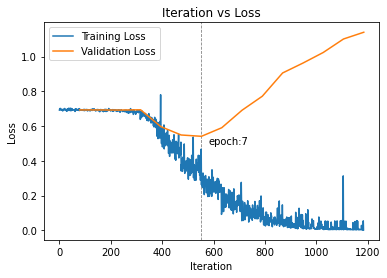

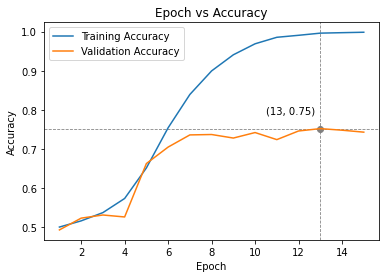

In [198]:
plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

## 5. Experiment

In [ ]:
import csv

"""
Experiment Different Hyperparameters with Grid Search method. 
"""
loss_name = 'CrossEntropy'
# loss_name = 'Tversky'

# optimizer_name = 'SGD'
optimizer_name = 'Adam'
# optimizer_name = 'AdaGrad'

# learning rate
lr_search_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]   # learning rate list
batch_search_list = [16,32,64]               # batch size list
epochs = 1
    
# Record the result into a CSV file
file_name = loss_name + "_" + optimizer_name + '.csv'

"""
Do Experiments with Different Hyperparameters
"""
with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Learning Rate", "Batch Size","Epochs","Loss Function", "Optimizer", "Accuracy", "Validation Loss"])
    
    for lr in lr_search_list:
        print("Test for Learning Rate: ", lr)
        for batch_size in batch_search_list:
            print("Test for Batch Size: ", batch_size)
            
            # Initialize the model
#             model = get_model(model_name)
            model = model
            
            # Get Loss Function and Optimizer
#             loss_function = get_loss_function(loss_name)
#             optimizer = get_optimizer(model, optimizer_name, learning_rate)
            optimizer = optim
            
            # Train the model and get the validation result
            train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train(
                                                                                                model = model,
                                                                                                batch_size = batch_size,
                                                                                                epochs = epochs,
                                                                                                optimizer = optimizer,
                                                                                #                 loss_function = loss_function
                                                                                            )
            
            # Record the validation result 
            writer.writerow([lr, batch_size, epochs, loss_name, optimizer_name, val_accuracy_list[-1], val_loss_list[-1]])